# CartPole — Apprentissage par renforcement avec approximation de fonctions


Ce notebook explore différents algorithmes d’**Apprentissage par Renforcement (RL)** appliqués à
l’environnement **CartPole-v1** de Gymnasium.  
Il montre comment gérer des **états continus** à l’aide de **TensorFlow (Keras)** pour
l’approximation de fonctions (value et action-value).

Algorithmes implémentés :
- **TD(0)** — Approximation de la value function V(s)
- **SARSA** — Apprentissage on-policy de Q(s, a)
- **Q-Learning** — Apprentissage off-policy de Q(s, a)
- **REINFORCE** — Policy gradient basé sur des épisodes complets
- **Actor–Critic** — Méthode combinant policy et value networks (avantage A(s, a))

Caractéristiques principales :
- Utilise **Gymnasium** (successeur de `gym`) pour une interface moderne et stable.
- Garde l’espace d’état **continu**, en utilisant de petits réseaux de neurones (MLP) pour approximer V(s) ou Q(s, a).
- Conçu pour un usage **éducatif et expérimental**, fonctionnant sur **CPU** sans besoin de GPU.
- Chaque algorithme est implémenté **from scratch** pour la clarté et la compréhension.
- Pour des résultats reproductibles : fixer les seeds et ajuster le nombre d’épisodes selon la machine.

In [1]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML
from matplotlib import animation
from tqdm.notebook import tqdm

## 1. Exploration de l'environnement CartPole

[CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) est un environnement de contrôle classique dans l'apprentissage par renforcement, **faisant partie de la nouvelle bibliothèque [Gymnasium](https://gymnasium.farama.org/) d'OpenAI**. L'objectif est d'équilibrer un poteau attaché à un chariot qui se déplace le long d'une piste.

<img src="https://miro.medium.com/max/600/1*v8KcdjfVGf39yvTpXDTCGQ.gif" width="45.5%" />

<img src="https://imgs.search.brave.com/WZ8YYAWJKo-L9N3w1KtCOEcAYqxUr7QytuTa6XuaNHs/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9naXRo/dWIuY29tL2xlb25q/b3Zhbm92aWMvZHJs/LXBvbGljeS1ncmFk/aWVudC1jYXJ0cG9s/ZS9yYXcvbWFpbi9p/bWFnZXMvY2FydHBv/bGVfZW52LnBuZw" width="52%" />

- **Observation (state)** : vecteur continu de dimension 4 :
  1. `x` : cart position (≈ range `[-4.8, 4.8]`)
  2. `x_dot` : cart velocity (unbounded en théorie)
  3. `θ` (theta) : pole angle (≈ range `[-0.418, 0.418]` radians ≈ ±24°)
  4. `θ_dot` : pole angular velocity (unbounded en théorie)
— Les deux dernières composantes (angle, angular velocity) sont généralement les plus informatives pour maintenir le pole upright.
- **Action space** : discret, 2 actions (`0` = push left, `1` = push right).
- **Reward** : +1 pour chaque step où le pole est maintenu ; objectif d’obtenir la plus longue durée possible (max 500 steps par épisode pour `CartPole-v1` by default).
- **Termination** : episode termine si `|x| > 4.8` (cart out of bounds) ou `|θ| > 0.418` rad (pole fallen) — Gymnasium retourne `terminated=True`. `truncated=True` si épisode atteint `max_episode_steps`.

In [2]:
env = gym.make('CartPole-v1', render_mode=None)
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)
obs, info = env.reset()
print('Initial observation:', obs)
print("-"*20)
for _ in range(5):
    a = env.action_space.sample()
    obs, r, terminated, truncated, info = env.step(a)
    print('action:', a, '\t-> obs:', obs, '\treward:', r, '\tdone?:', terminated or truncated)
env.close()

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)
Initial observation: [-0.03199361 -0.00556936 -0.0006384   0.04478744]
--------------------
action: 0 	-> obs: [-3.2104995e-02 -2.0068215e-01  2.5734483e-04  3.3726886e-01] 	reward: 1.0 	done?: False
action: 1 	-> obs: [-0.03611864 -0.00556386  0.00700272  0.04466711] 	reward: 1.0 	done?: False
action: 0 	-> obs: [-0.03622992 -0.20078553  0.00789606  0.3395512 ] 	reward: 1.0 	done?: False
action: 1 	-> obs: [-0.04024563 -0.00577681  0.01468709  0.04936868] 	reward: 1.0 	done?: False
action: 0 	-> obs: [-0.04036116 -0.20110625  0.01567446  0.34664908] 	reward: 1.0 	done?: False


## 2) Fonctions utilitaires
Nous definissons 3 fonctions utilitaires:
- `build_mlp`: Construit un petit réseau de neurones multicouches (MLP) pour l'approximation de fonctions.
- `plot_reward`: Trace la courbe de récompense lissée au fil des épisodes pour visualiser l'apprentissage.
- `record_policy`: Enregistre une vidéo de la politique de l'agent dans l'environnement.

In [7]:
def build_mlp(input_dim, output_dim, hidden_sizes=(32,32), activation='relu'):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for h in hidden_sizes:
        model.add(layers.Dense(h, activation=activation))
    model.add(layers.Dense(output_dim, activation=None))
    return model

In [20]:
def plot_rewards(list_of_rewards, labels, title="Courbes d'apprentissage"):
    plt.figure(figsize=(8,4))
    for rewards, label in zip(list_of_rewards, labels):
        # smooth
        w = max(1, len(rewards)//50)
        smooth = np.convolve(rewards, np.ones(w)/w, mode='valid')
        plt.plot(smooth, label=label)
    plt.legend()
    plt.xlabel('Épisodes')
    plt.ylabel('Récompense totale')
    plt.title(title)
    plt.show()

In [9]:
def record_policy(model, model_type='q', max_steps=1000):
    env = gym.make('MountainCar-v0', render_mode='rgb_array')
    obs, info = env.reset()
    frames = []

    for _ in range(max_steps):
        frames.append(env.render())
        if model_type == 'q':
            qs = model(obs.reshape(1, -1).astype(np.float32)).numpy()[0]
            a = int(np.argmax(qs))
        else:
            logits = model(obs.reshape(1, -1).astype(np.float32)).numpy()[0]
            probs = tf.nn.softmax(logits).numpy()
            a = int(np.argmax(probs))
        obs, r, term, trunc, info = env.step(a)
        if term or trunc:
            frames.append(env.render())
            break
    env.close()

    # Convert frames to animation
    fig = plt.figure()
    im = plt.imshow(frames[0])

    def animate(i):
        im.set_array(frames[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
    plt.close(fig)
    return HTML(anim.to_jshtml())

## 3. Les methodes basees sur les valeurs

In [4]:
def discretize_state(state, bins):
    """Convert continuous state to discrete tuple index."""
    return tuple(np.digitize(s, b) for s, b in zip(state, bins))

In [12]:
def record_policy_sarsa_q_learning(model, model_type='q', max_steps=500):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    obs, info = env.reset()
    frames = []

    for _ in range(max_steps):
        frames.append(env.render())
        qs = model(obs.reshape(1, -1).astype(np.float32)).numpy()[0]
        a = int(np.argmax(qs))
        obs, r, term, trunc, info = env.step(a)
        if term or trunc:
            frames.append(env.render())
            break
    env.close()

    # Créer une animation matplotlib
    fig = plt.figure()
    im = plt.imshow(frames[0])

    def animate(i):
        im.set_array(frames[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
    plt.close(fig)
    return HTML(anim.to_jshtml())

In [16]:
def train_value_based(method='q_learning', episodes=1000, gamma=0.99, alpha=0.001,
                      eps_0=1.0, eps_min=0.05, k=0.0009):
    env = gym.make('CartPole-v1')
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    model = build_mlp(n_states, n_actions)
    optimizer = optimizers.Adam(alpha)
    loss_fn = tf.keras.losses.MeanSquaredError()

    rewards_history = []

    for ep in tqdm(range(episodes), desc=f"Training {method.upper()}"):
        obs, info = env.reset()
        eps = max(eps_min, eps_0 - k * ep)
        total_reward = 0
        done = False

        # choisir action initiale
        qs = model(obs.reshape(1, -1)).numpy()[0]
        if np.random.rand() < eps:
            action = np.random.randint(n_actions)
        else:
            action = np.argmax(qs)

        while not done:
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # choisir action suivante selon la politique epsilon-greedy
            next_qs = model(next_obs.reshape(1, -1)).numpy()[0]
            if np.random.rand() < eps:
                next_action = np.random.randint(n_actions)
            else:
                next_action = np.argmax(next_qs)

            # calcul de la cible (target)
            if method == 'sarsa':
                target = reward + (0 if done else gamma * next_qs[next_action])
            else:  # q_learning
                target = reward + (0 if done else gamma * np.max(next_qs))

            # apprentissage (mise à jour du modèle)
            with tf.GradientTape() as tape:
                q_values = model(obs.reshape(1, -1))
                q_pred = q_values[0, action]
                loss = loss_fn([[target]], [[q_pred]])
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            obs = next_obs
            action = next_action if method == 'sarsa' else np.argmax(next_qs)

        rewards_history.append(total_reward)

    env.close()
    return model, rewards_history

In [23]:
episodes = 800
sarsa_model, sarsa_rewards = train_value_based('sarsa', episodes=episodes)
q_model, q_rewards = train_value_based('q_learning', episodes=episodes)

Training SARSA:   0%|          | 0/800 [00:00<?, ?it/s]

Training Q_LEARNING:   0%|          | 0/800 [00:00<?, ?it/s]

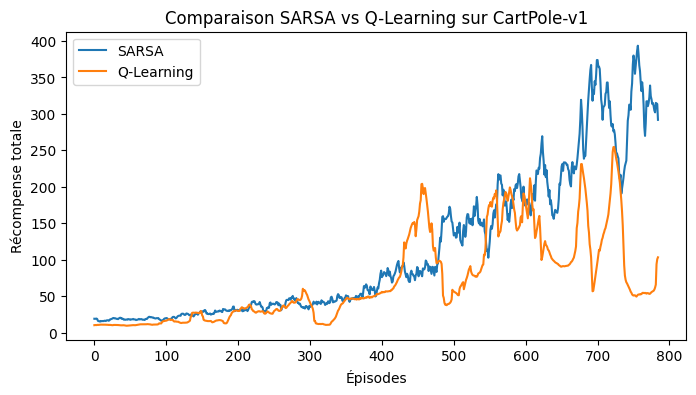

In [24]:
plot_rewards(
    list_of_rewards=[sarsa_rewards, q_rewards],
    labels=['SARSA', 'Q-Learning'],
    title="Comparaison SARSA vs Q-Learning sur CartPole-v1"
)

In [25]:
record_policy_sarsa_q_learning(q_model, model_type='q', max_steps=2_000)

In [26]:
record_policy_sarsa_q_learning(sarsa_model, model_type='sarsa', max_steps=2_000)

## Deep DQN

In [31]:
from collections import deque
import random

In [ ]:
def record_policy(model, model_type='q', max_steps=500):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    obs, info = env.reset()
    frames = []

    for _ in range(max_steps):
        frames.append(env.render())
        qs = model(obs.reshape(1, -1).astype(np.float32)).numpy()[0]
        a = int(np.argmax(qs))
        obs, r, term, trunc, info = env.step(a)
        if term or trunc:
            frames.append(env.render())
            break
    env.close()

    fig = plt.figure()
    im = plt.imshow(frames[0])

    def animate(i):
        im.set_array(frames[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
    plt.close(fig)
    return HTML(anim.to_jshtml())

In [27]:
def train_dqn(episodes=500, gamma=0.99, alpha=0.001,
              eps_start=1.0, eps_min=0.05, eps_decay=0.995,
              batch_size=64, buffer_size=50000, target_update=50):

    env = gym.make('CartPole-v1')
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n

    q_model = build_mlp(n_states, n_actions)
    target_model = build_mlp(n_states, n_actions)
    target_model.set_weights(q_model.get_weights())

    optimizer = optimizers.Adam(learning_rate=alpha)
    loss_fn = tf.keras.losses.MeanSquaredError()

    memory = deque(maxlen=buffer_size)
    rewards_history = []

    eps = eps_start

    for ep in tqdm(range(episodes), desc="Training DQN"):
        obs, info = env.reset()
        total_reward = 0
        done = False

        while not done:
            # --- Sélection d'action (ε-greedy)
            if np.random.rand() < eps:
                action = np.random.randint(n_actions)
            else:
                q_values = q_model(obs.reshape(1, -1)).numpy()
                action = int(np.argmax(q_values))

            # --- Exécution dans l’environnement
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            memory.append((obs, action, reward, next_obs, done))
            obs = next_obs
            total_reward += reward

            # --- Entraînement par mini-lot (batch)
            if len(memory) >= batch_size:
                batch = random.sample(memory, batch_size)
                obs_batch, act_batch, rew_batch, next_batch, done_batch = map(np.array, zip(*batch))

                # cibles de Q-learning
                next_qs = target_model(next_batch).numpy()
                targets = rew_batch + gamma * (1 - done_batch) * np.max(next_qs, axis=1)

                with tf.GradientTape() as tape:
                    qs = q_model(obs_batch)
                    act_onehot = tf.one_hot(act_batch, n_actions)
                    pred = tf.reduce_sum(qs * act_onehot, axis=1)
                    loss = loss_fn(targets, pred)
                grads = tape.gradient(loss, q_model.trainable_variables)
                optimizer.apply_gradients(zip(grads, q_model.trainable_variables))

        # --- mise à jour du modèle cible
        if ep % target_update == 0:
            target_model.set_weights(q_model.get_weights())

        # --- décroissance de epsilon
        eps = max(eps_min, eps * eps_decay)
        rewards_history.append(total_reward)

    env.close()
    return q_model, rewards_history

In [ ]:
dqn_model, dqn_rewards = train_dqn(episodes=800)

Training DQN:   0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
plot_rewards(
    list_of_rewards=[sarsa_rewards, q_rewards, dqn_rewards],
    labels=['SARSA', 'Q-Learning', 'DQN'],
    title="Comparaison SARSA vs Q-Learning vs DQN sur CartPole-v1"
)

In [ ]:
record_policy_sarsa_q_learning(dqn_model, model_type='q', max_steps=2_000)